In [131]:
#We are going to create a Neural Network in order to predict a image classification of cats vs dogs

##VARIABLES CHANGED
batch_size= 15
seedVal = 123;
#opFunction = "Nesterov"
#opFunction="Adam"
opFunction="RMSprop"
NetStructure = "noBN"
lr = 0.001
### PREAMBLE ################################################################
# allows the images to be displayed in the jupyter notebook
%matplotlib inline

# torch and torchvision related
import torch

dtype = torch.cuda.FloatTensor
import torchvision as tv
import torchvision.transforms as transforms
import torchvision.datasets as datasets

from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


# image library
from PIL import Image

# some numeric stuff
import numpy as np
import random
import matplotlib.pyplot as plt

# file input/output libraries
import fnmatch
import os

# datetime
import datetime
now = datetime.datetime.now()

### OPTIONS #################################################################
# may want to later set from command line

# set random seed value

# at which epochs to record training/validation error
epochsConsidered = [15, 20, 25]
#epochsConsidered = [150, 200, 250, 300, 350, 400]
#epochsConsidered = [5, 10, 25, 50, 100, 150, 200, 250,300]
#epochsConsidered = [5, 10, 25, 50]
saveNetEpochsConsidered = True;

### PATHS ###################################################################

pathTrain = './data/FinalProjectTrainValTest/Train/'
pathVal = './data/FinalProjectTrainValTest/Val/'
pathOutput = './output/'

### FUNCTIONS ###############################################################

# function to compute the percentage accuracy in categorizing images
def computeAccuracy(net, dataSubset):
    correct = 0
    total = 0
    # don't want batches, want to compute over the whole dataset
    dataSubsetLoader = torch.utils.data.DataLoader(dataSubset, num_workers=2)
    for data in dataSubsetLoader:
        images, labels = data  
        outputs = net(Variable(images))
        print(outputs)
        _, predicted = torch.max(outputs.data, 1) 
        total += labels.size(0)
        correct += (predicted == labels).sum()

    percentAccuracy = 100 * correct / total
    print('Accuracy of the network is: %d %%' % (
        percentAccuracy))
    
    return(percentAccuracy)

In [132]:

# ### CONVERT IMAGES FROM .tif TO .png ########################################
# # ugly code, should make function rather than copy the same lines of code
# # for Train and Val, as can easily make mistakes
classes = ['Cats','Dogs'];
for k in range(0,2): ### CAS: change to range(0,8)
    allTrainFiles = fnmatch.filter(os.listdir(pathTrain+classes[k]), '*.tif');
    allValFiles = fnmatch.filter(os.listdir(pathVal+classes[k]), '*.tif');
#     print(k)
#     print(allTrainFiles)
    for j in range(0,len(allTrainFiles)):
            img = Image.open(pathTrain+classes[k]+'/'+allTrainFiles[j])
            newName = os.path.splitext(pathTrain+classes[k]+'/'+allTrainFiles[j])[0]+'.png'
            img.save(newName)
            
    for j in range(0,len(allValFiles)):
            img = Image.open(pathVal+classes[k]+'/'+allValFiles[j])
            newName = os.path.splitext(pathVal+classes[k]+'/'+allValFiles[j])[0]+'.png'
            img.save(newName)

In [133]:
# write what the transforms should be
# From website: Normalize an tensor image with mean and standard deviation. 
# Given mean: (M1,...,Mn)  and std: (S1,..,Sn) for n channels, this transform 
# will normalize each channel of the input
# for some reason resize has to come before ToTensor
transform = transforms.Compose( #lookup transforms.compose
    [transforms.Resize(size=32),
     transforms.ToTensor(), 
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# load the train and val dataset
#I switch from 4 to 10 on batch_size for both valset and trainsettrainset
trainset = datasets.ImageFolder(root=pathTrain,transform=transform)

#trainloader = torch.utils.data.DataLoader(trainset, batch_size=10,shuffle=True, num_workers=2)

#updated the batch_size: from 10 to 25
trainloader = torch.utils.data.DataLoader(trainset, batch_size = batch_size,shuffle=True, num_workers=2)

#batch_size vs memory???----> look this up!
# if bathc_size >1 then batch _norm layer helps with regularization.

valset = datasets.ImageFolder(root=pathVal, transform=transform)
valloader = torch.utils.data.DataLoader(valset, shuffle=True, num_workers=2)

### CAC classes must be in alphabetical order
classes = ('Cats', 'Dogs')
classes = sorted(classes) 
print(classes)

['Cats', 'Dogs']



(0 ,0 ,.,.) = 
  0.3098  0.0353 -0.0980  ...   0.5451  0.5294  0.5529
  0.1137 -0.5294 -0.8039  ...   0.0902 -0.1137  0.0980
 -0.2235 -0.8118 -0.9529  ...  -0.7882 -0.8980 -0.6314
           ...             ⋱             ...          
 -0.9529 -0.8588 -0.7098  ...   0.0667  0.1765  0.1922
 -0.8902 -0.8510 -0.8039  ...   0.1137  0.3412  0.3020
 -0.9059 -0.8980 -0.8510  ...  -0.0353  0.3098  0.3412

(0 ,1 ,.,.) = 
  0.3098  0.0353 -0.0980  ...   0.5451  0.5294  0.5529
  0.1137 -0.5294 -0.8039  ...   0.0902 -0.1137  0.0980
 -0.2235 -0.8118 -0.9529  ...  -0.7882 -0.8980 -0.6314
           ...             ⋱             ...          
 -0.9529 -0.8588 -0.7098  ...   0.0667  0.1765  0.1922
 -0.8902 -0.8510 -0.8039  ...   0.1137  0.3412  0.3020
 -0.9059 -0.8980 -0.8510  ...  -0.0353  0.3098  0.3412

(0 ,2 ,.,.) = 
  0.3098  0.0353 -0.0980  ...   0.5451  0.5294  0.5529
  0.1137 -0.5294 -0.8039  ...   0.0902 -0.1137  0.0980
 -0.2235 -0.8118 -0.9529  ...  -0.7882 -0.8980 -0.6314
           ...   

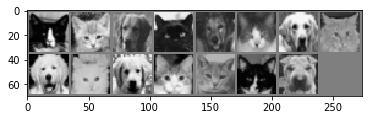

In [134]:
### PRINT IMAGES TO SCREEN TO VISUALIZE ####################################

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0))) #lookup np.transpose
    
# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

##Update
print(images)
#print(labels) #Dont need to see this for now

# show images
imshow(tv.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(15)))

In [135]:
### NETWORK ARCHITECTURE #############################################

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        #self.conv1 = nn.Conv2d(3, 6, 5)
        self.conv1 = nn.Conv2d(3,6,5)
        self.pool = nn.MaxPool2d(2, 2)
        #self.conv2 = nn.Conv2d(6, 16, 5)
        self.conv2 = nn.Conv2d(6,16,5)
        #####################
        #What if we add a batch normalization Layer??
        #self.conv2_bn = nn.BatchNorm2d(16)
        ######
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        #self.fc1 = nn.Linear(5 * 5, 120)
        self.fc2 = nn.Linear(120, 80)
        self.fc3 = nn.Linear(80,2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        
        x = self.pool(F.relu(self.conv2(x)))
        
        #x = self.conv2_bn(self.conv2(x))
        #print x.shape()
        #x = F.relu(self.pool(x))
       # x = x.view(-1, 16 * 5 * 5)
        x = x.view(-1, 16*5 * 5)
        x = F.relu(self.fc1(x)) #vector of size 1 by 120 
        x = F.relu(self.fc2(x)) #vector of size 1 by 84
        x = self.fc3(x)
        return x

net = Net()

In [136]:
# print functions used in the network
net

Net(
  (conv1): Conv2d (3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (conv2): Conv2d (6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120)
  (fc2): Linear(in_features=120, out_features=80)
  (fc3): Linear(in_features=80, out_features=2)
)

In [137]:
### SET UP TO DETERMINE BEST NUMBER OF EPOCHS (HYPERPARAMETER)
# for each epoch considered, find the training and validation Accuracy
# initialize vectors here
trainAccuracy = [0]*len(epochsConsidered)
valAccuracy = [0]*len(epochsConsidered)
count = 0;

#IF statements for SGD Nesterov and Adam optimizer

if opFunction == "Nesterov":
    optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.9, nesterov=True)
if opFunction == "Adam":
    optimizer = optim.Adam(net.parameters(), lr=lr, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)
    
##ADDED A NEW OPTIMIZER##    
if opFunction == "RMSprop":
    optimizer = optim.RMSprop(net.parameters(), lr=lr, alpha=0.99, eps=1e-08, weight_decay=0, momentum=0, centered=False)

In [138]:
### TRAIN NETWORK ######################################################

# set random seed
random.seed(seedVal);

criterion = nn.CrossEntropyLoss() 
#optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9, nesterov=True)
##Added "nesterov = True" change maded on 3/25

### CAS: increased the number of epochs get better result
for epoch in range(np.max(epochsConsidered)):  # loop over the dataset multiple times  #We reduced the ranget (5)##

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data

        # wrap them in Variable
        inputs, labels = Variable(inputs), Variable(labels)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.data[0]
        # print(loss.data)
        if i % 5 == 4:    # print every 5 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss/5)) #try divide by 5
            running_loss = 0.0
            
    # For selected epochs, compute training and val (see note)
    # acccuracy, and save the network so that it can be reloaded
    if (epoch+1) in epochsConsidered:
        trainAccuracy[count] = computeAccuracy(net, trainset)
        valAccuracy[count] = computeAccuracy(net, valset)
        count = count + 1
        # save networks at the different epochs, to later load
        if (saveNetEpochsConsidered):
            saveFilename = str(now.strftime("%Y-%m-%d")) + ('Original%s_epochs.pth' % (epoch+1))
            savePath = os.path.join(pathOutput, 'networks', saveFilename)
            torch.save(net.cpu().state_dict(), savePath)
        
print('Finished Training')

[1,     5] loss: 0.693
[2,     5] loss: 0.644
[3,     5] loss: 0.476
[4,     5] loss: 0.362
[5,     5] loss: 0.256
[6,     5] loss: 0.178
[7,     5] loss: 0.162
[8,     5] loss: 0.154
[9,     5] loss: 0.081
[10,     5] loss: 0.061
[11,     5] loss: 0.056
[12,     5] loss: 0.053
[13,     5] loss: 0.035
[14,     5] loss: 0.012
[15,     5] loss: 0.005
Variable containing:
 4.1601 -6.3567
[torch.FloatTensor of size 1x2]

Variable containing:
 3.9576 -5.8661
[torch.FloatTensor of size 1x2]

Variable containing:
 4.9782 -7.7991
[torch.FloatTensor of size 1x2]

Variable containing:
 1.4001 -2.6261
[torch.FloatTensor of size 1x2]

Variable containing:
 3.9197 -5.8189
[torch.FloatTensor of size 1x2]

Variable containing:
 4.9176 -7.3085
[torch.FloatTensor of size 1x2]

Variable containing:
 2.3755 -3.6557
[torch.FloatTensor of size 1x2]

Variable containing:
 3.1224 -4.6436
[torch.FloatTensor of size 1x2]

Variable containing:
 5.5873 -8.3761
[torch.FloatTensor of size 1x2]

Variable containing

Variable containing:
-6.0155  6.0203
[torch.FloatTensor of size 1x2]

Variable containing:
-6.4533  6.4426
[torch.FloatTensor of size 1x2]

Variable containing:
-2.5291  2.2580
[torch.FloatTensor of size 1x2]

Accuracy of the network is: 100 %
Variable containing:
 4.2925 -6.4103
[torch.FloatTensor of size 1x2]

Variable containing:
 2.0411 -3.1755
[torch.FloatTensor of size 1x2]

Variable containing:
 4.6705 -7.0501
[torch.FloatTensor of size 1x2]

Variable containing:
-0.9181  0.3987
[torch.FloatTensor of size 1x2]

Variable containing:
 3.4656 -5.1395
[torch.FloatTensor of size 1x2]

Variable containing:
 1.0095 -1.8606
[torch.FloatTensor of size 1x2]

Variable containing:
 4.0226 -6.0106
[torch.FloatTensor of size 1x2]

Variable containing:
-0.9072  0.0487
[torch.FloatTensor of size 1x2]

Variable containing:
 2.6413 -3.9937
[torch.FloatTensor of size 1x2]

Variable containing:
-0.4533 -0.1732
[torch.FloatTensor of size 1x2]

Variable containing:
 1.8297 -2.8314
[torch.FloatTensor 


Variable containing:
-6.9049  6.8134
[torch.FloatTensor of size 1x2]

Variable containing:
-2.3209  1.9860
[torch.FloatTensor of size 1x2]

Variable containing:
-3.2801  2.8534
[torch.FloatTensor of size 1x2]

Variable containing:
-2.5940  2.3714
[torch.FloatTensor of size 1x2]

Variable containing:
-8.6697  8.5298
[torch.FloatTensor of size 1x2]

Variable containing:
-7.4431  7.3419
[torch.FloatTensor of size 1x2]

Variable containing:
-2.4828  2.3786
[torch.FloatTensor of size 1x2]

Variable containing:
-2.6296  2.4149
[torch.FloatTensor of size 1x2]

Variable containing:
-4.5789  3.9865
[torch.FloatTensor of size 1x2]

Variable containing:
-3.9915  3.8251
[torch.FloatTensor of size 1x2]

Variable containing:
-5.1828  4.9957
[torch.FloatTensor of size 1x2]

Variable containing:
-3.5357  3.1505
[torch.FloatTensor of size 1x2]

Variable containing:
-7.2051  7.0971
[torch.FloatTensor of size 1x2]

Variable containing:
-2.9226  2.5316
[torch.FloatTensor of size 1x2]

Variable containing

Variable containing:
-2.9961  2.5387
[torch.FloatTensor of size 1x2]

Variable containing:
-5.4339  5.3401
[torch.FloatTensor of size 1x2]

Variable containing:
-7.7360  7.6209
[torch.FloatTensor of size 1x2]

Variable containing:
-2.7206  2.3436
[torch.FloatTensor of size 1x2]

Variable containing:
-3.7302  3.2276
[torch.FloatTensor of size 1x2]

Variable containing:
-2.9550  2.7016
[torch.FloatTensor of size 1x2]

Variable containing:
-9.7343  9.5581
[torch.FloatTensor of size 1x2]

Variable containing:
-8.3376  8.2131
[torch.FloatTensor of size 1x2]

Variable containing:
-2.8570  2.7394
[torch.FloatTensor of size 1x2]

Variable containing:
-2.9930  2.7318
[torch.FloatTensor of size 1x2]

Variable containing:
-5.0176  4.2899
[torch.FloatTensor of size 1x2]

Variable containing:
-4.3238  4.0918
[torch.FloatTensor of size 1x2]

Variable containing:
-5.4945  5.1696
[torch.FloatTensor of size 1x2]

Variable containing:
-3.8789  3.3698
[torch.FloatTensor of size 1x2]

Variable containing:

In [139]:
np.max(valAccuracy)

83.333333333333329

In [140]:
epochsConsidered[np.argmax(valAccuracy)]

15

In [141]:
trainAccuracy

[100.0, 100.0, 100.0]

In [142]:
trainAccuracy[np.argmax(valAccuracy)]

100.0

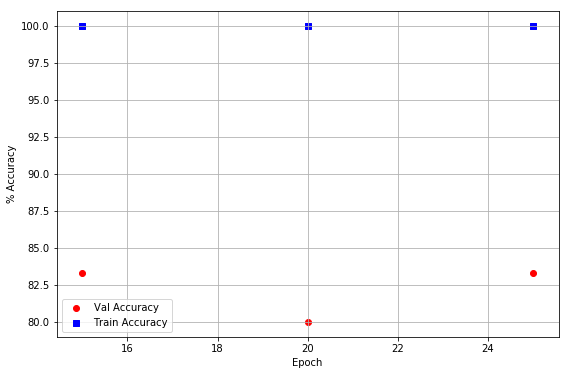

In [143]:
### FIGURE TO SHOW TRAIN AND VAL ERROR ############################

# initialize figure
plt.figure(figsize=(9, 6)) 

# the two scatter grap data sets
data1 = plt.scatter(epochsConsidered, valAccuracy, color='r', marker='o', label='Val Accuracy')
data2 = plt.scatter(epochsConsidered, trainAccuracy, color='b', marker='s', label='Train Accuracy')

# formatting
plt.xlabel('Epoch')
plt.ylabel('% Accuracy')
plt.legend()
plt.grid()

# save to file
fig = plt.gcf()
fig.savefig(pathOutput + str(now.strftime("%Y-%m-%d")) + opFunction+"-" + str(lr)+"-" + str(seedVal)+"-"+ NetStructure+"-"+ str(batch_size)+
            '.png', bbox_inches="tight")

In [144]:
# Check that you can load a previous network
# !!! This loads the saved network into the variable net, overwritting net !!!
# But the last saved net can be reloaded!
#fileToLoad = '2018-01-31Original25_epochs.pth'
#net.load_state_dict(torch.load(os.path.join(pathOutput, 'networks', fileToLoad)))
computeAccuracy(net, valset)

Variable containing:
 6.2130 -9.1592
[torch.FloatTensor of size 1x2]

Variable containing:
 3.0603 -4.6565
[torch.FloatTensor of size 1x2]

Variable containing:
 6.4411 -9.5397
[torch.FloatTensor of size 1x2]

Variable containing:
-1.0258  0.2335
[torch.FloatTensor of size 1x2]

Variable containing:
 4.7196 -6.8974
[torch.FloatTensor of size 1x2]

Variable containing:
 1.1117 -2.3245
[torch.FloatTensor of size 1x2]

Variable containing:
 5.6195 -8.2894
[torch.FloatTensor of size 1x2]

Variable containing:
-0.6068 -0.7855
[torch.FloatTensor of size 1x2]

Variable containing:
 3.7366 -5.5511
[torch.FloatTensor of size 1x2]

Variable containing:
-0.9637  0.0608
[torch.FloatTensor of size 1x2]

Variable containing:
 2.8250 -4.2359
[torch.FloatTensor of size 1x2]

Variable containing:
 3.9600 -5.9965
[torch.FloatTensor of size 1x2]

Variable containing:
 4.7278 -7.1107
[torch.FloatTensor of size 1x2]

Variable containing:
-8.3127  8.2621
[torch.FloatTensor of size 1x2]

Variable containing:

83.33333333333333

In [145]:
pcaloader = torch.utils.data.DataLoader(trainset, batch_size=640,shuffle=True, num_workers=2)
for i, data in enumerate(pcaloader, 0):
    images, labels = data  
    print(images.shape)

torch.Size([130, 3, 32, 32])


In [146]:
print(labels)


 1
 1
 1
 1
 0
 0
 1
 0
 0
 0
 0
 1
 0
 1
 0
 0
 1
 1
 0
 0
 1
 0
 1
 1
 1
 0
 1
 1
 0
 0
 1
 1
 0
 0
 0
 0
 0
 0
 1
 1
 1
 0
 0
 1
 1
 0
 1
 1
 0
 0
 1
 1
 0
 0
 0
 1
 1
 1
 1
 1
 0
 0
 1
 0
 1
 1
 0
 1
 1
 1
 1
 0
 0
 0
 1
 1
 1
 0
 1
 0
 1
 1
 0
 1
 1
 0
 0
 1
 0
 0
 1
 0
 0
 0
 0
 0
 1
 1
 1
 0
 1
 1
 0
 0
 0
 1
 0
 1
 1
 0
 1
 0
 0
 0
 0
 0
 1
 0
 1
 0
 1
 1
 0
 1
 0
 1
 0
 1
 0
 1
[torch.LongTensor of size 130]



In [147]:
pcaImages = images.view(-1,3*32*32)

In [148]:
print(pcaImages)


-0.1059 -0.2863 -0.5686  ...   0.4667 -0.3412 -0.5922
 0.3647  0.2392  0.2706  ...  -0.5922 -0.6392 -0.7333
-0.1765 -0.1137 -0.0510  ...  -0.0980 -0.0824 -0.0431
          ...             ⋱             ...          
-0.8745 -0.8824 -0.8745  ...  -0.2314 -0.5216 -0.8118
-0.2941 -0.4902 -0.5686  ...  -0.1765 -0.0510 -0.0275
 0.1529 -0.3647 -0.6863  ...  -0.2314 -0.3725 -0.7882
[torch.FloatTensor of size 130x3072]

